#  Прогнозирование оттока телеком компании

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Компания планирует минимизировать отток клиентов путем предоставления специальных условий для категории лиц, потенциально решивших прекратить сотрудничество с ними. Таким образом, целью данной работы является создание модели, которая сможет определять данную группу лиц с точностью не менее 0.85 ROC-AUC. Финальной задачей же является минимизация оттока клиентов для получения большей выручки. 

# План выполнения проекта:

1. *Предварительная обработка данных*
- Изучение каждого датафрейма, определение количества пропущенных значений, изучение типов данных, содержащихся в нем, и проверка их соответсвия характеру столбца;
- Изучение распределения значений, при необходимости, построение графиков;
- Внесение изменений при обнаружении какого-либо несоответствия или, например, удаление аномальных значений, обнаруженных на прошлом этапе;
- Объединение датафреймов;
2. Исследовательский анализ данных
- Определение целевого признака
- Исследовательский анализ признаков
- Исследование корреляции признаков, построение матрицы корреляции и определение финальных признаков
3. *Обучение модели*
- Разделение выборки на тренировочную и тестовую (в данном случае не используется валидационная выборка, так как проверка будет осуществляться кросс-валидацией)
- Кодирование категориальных признаков;
- Обучение модели леса деревьев  
- Обучении модели CatBoost
- Сравнение финальных метрик ROC-AUC и accuracy после кроссвалидации и определение наиболее подходящей модели
5. *Тестирование модели*
- Использование модели, выбранной на прошлом шаге, на тестовых данных
- Определение финальных значений ROC-AUC и Accuracy, проверка их соответсвия условию
6. *Вывод*
- Общий вывод.

## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score

## Предварительная обработка данных 

В первую очередь, загрузим каждый датасет и выведем общую информацию о нем:

### personal_new

In [4]:
try:
    personal = pd.read_csv('/datasets/personal_new.csv')
except: 
    personal = pd.read_csv('personal_new.csv')
#выведем первые 5 строк датафрейма:
display(personal.head())
print()
#Выведем общую информацию о датафрейме:
display(personal.info())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Датафрейм состоит из 7043 строк и 5 столбцов: 
- `customerID` - уникальный идентификатор покупателя 
- `gender` - пол 
- `SeniorCitizen` - является ли клиент пожилым человеком 
- `Partner` - состоит ли клиент в браке 
- `Dependents` - имеются ли иждивенцы 

Пропущенные значения отсутсвуют. Также, стоит обратить внимание на тип данных - `SeniorCitizen` имеет тип данных int, хотя также представляет бинарные значения, как и другие признаки. Так как данные в данном датафрейме, помимо идентификатора, представляют собой бинарные значения, метод "describe()" не нужен. Посмотрим распределение значений с помощью value_counts: 

In [5]:
print(personal['gender'].value_counts(normalize=True))
print()
print(personal['SeniorCitizen'].value_counts(normalize=True))
print()
print(personal['Partner'].value_counts(normalize=True))
print()
print(personal['Dependents'].value_counts(normalize=True))

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64


Таким образом, в выборке представлено примерно равное соотношение полов, 16% клиентов в выборке являются пожилыми людьми, также датафрейм имеет равное соотношение клиентов, как состоящих в браке, так и нет, и около 30% клиентов имеют иждивенцев.

In [6]:
#Пеереведем столбец SeniorCitizen к формату датафрейма для удобства при дальнейшем кодировании:
personal['SeniorCitizen'] = personal['SeniorCitizen'].apply(lambda x: 'No' if x == 0 else 'Yes')
display(personal.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


## contract_new

In [7]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
except: 
    contract = pd.read_csv('contract_new.csv')
#выведем первые 5 строк датафрейма:
display(contract.head())
print()
#Выведем общую информацию о датафрейме:
display(contract.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Датафрейм состоит из 7043 строк и 8 столбцов: 
- `customerID` - уникальный идентификатор клиента
- `BeginDate` - дата начала пользования услугой
- `EndDate` - дата окочания использования услуги(при наличии)
- `Type` - тип оплаты
- `PaperlessBilling` - безналичный расчет
- `PaymentMethod` - способ оплаты
- `MonthlyCharges` - ежемесячные траты на услуги
- `TotalCharges` - всего потрачено на услуги

Столбец TotalCharges имеет тип данных object, что противоречит харакетру данных в столбце. Переведем его в тип данных float. В связи с тем, что пустые значения в данном столбце обозначены знаком пробел (" "), метод info не выдает пропущенные значения. Поэтому, заменим данные значения на "0".

In [8]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', '0')
contract['TotalCharges'] = contract['TotalCharges'].astype(float)
#Отобразим количество пропущенных значений:
contract['TotalCharges'][contract['TotalCharges'] == 0].count()

11

In [9]:
#Выведем строки с пропусками:
contract[contract['TotalCharges']==0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.0


Можно обратить внимание, что все клиенты имеют годовой тип оплаты, а дата начала использования услуги-дата выгрузки базы данных. Таким образом - пропуски в столбце `TotalCharges` связаны с тем, что для данных клиентов не был выставлен счет. Также учитывая количество таких клиентов(11 к 7043) можем удалить данные строки, ведь кейсы данных клиентов не подходят для решения данной задачи, а именно определение оттока клиентов (клиенты пришли в дату выгрузки базы данных).

In [10]:
contract = contract[contract['TotalCharges'] != 0]
contract.reset_index(drop=True, inplace=True)

In [11]:
#Опишем два численных столбца, а именно `MonthlyCharges` и `TotalCharges` методом describe:
print(contract['MonthlyCharges'].describe())
print()
print(contract['TotalCharges'].describe())

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64


Столбец `MonthlyCharges` не содержит большого количества аномалий (разница между средним и медианой), чего нельзя сказать о столбце `TotalCharges`, изучим столбцы на предмет аномалий:

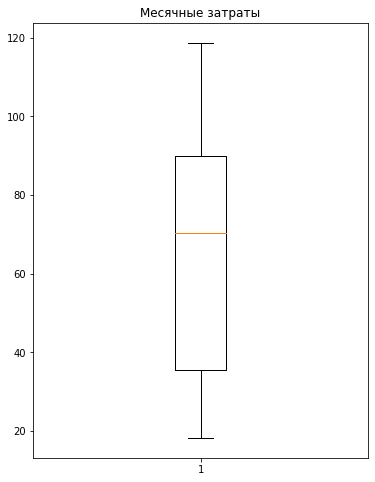

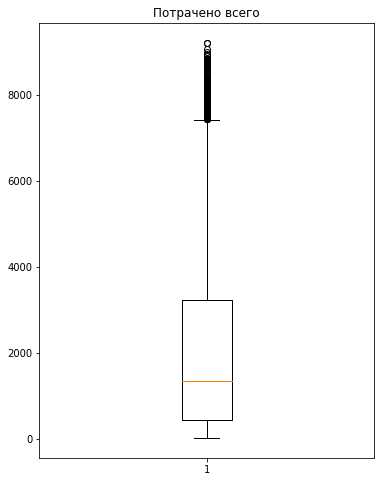

In [12]:
plt.figure(figsize=(6, 8))  
plt.boxplot(contract['MonthlyCharges'])
plt.title('Месячные затраты')
plt.show()
plt.figure(figsize=(6, 8))  
plt.boxplot(contract['TotalCharges'])
plt.title('Потрачено всего')
plt.show()

Столбец с месячными затратами не содержит аномальных значений. Столбец с суммарными затратами имеет "аномальные" значения выше 7500, однако, эти значения могут характеризовать пользователей, являющихся клиентами компании долгое время, поэтому, оставим их в датафрейме.

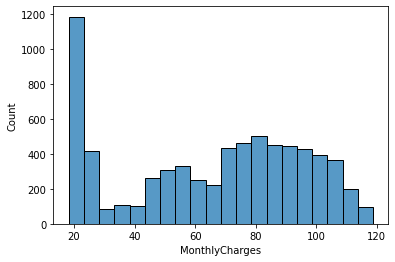

In [14]:
# Посмотрим распределение значений
sns.histplot(data=contract, x='MonthlyCharges', bins=20)
plt.show()

На гистограме виден пик в промежутке от 18 до 28 долларов. Таким образом, наибольшее количество пользователей имеют минимальный месячный чек. Однако, стоит отметить, что срзау за ней идет группа затрат, представленная значениями 78 и 88 долларов. Это может быть связано с тем, что наибольшее количество пользователей пользуются только 1 услугой.

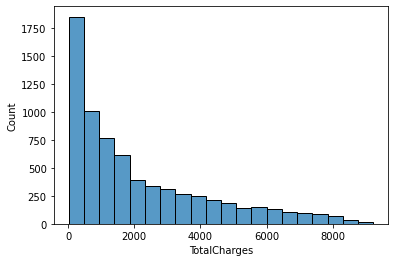

In [15]:
sns.histplot(data=contract, x='TotalCharges', bins=20)
plt.show()

Данная гистограмма имеет нисходящий тренд. Наибольшее количество пользователей потратило до 1000 долларов (это видно по резкой разнице между двумя столбцами). Начиная со значения 1900 у.е., гистограмма имеет более "плавное" изменения между группами. Начиная со значения 3800 долларов, количество клиентов составяет не более 500, что свидетельствует о том, что данные группы затрат не являются "стандартными" и являются, скорее, исключениями. 

## phone_new

In [16]:
try:
    phone = pd.read_csv('/datasets/phone_new.csv')
except: 
    phone = pd.read_csv('phone_new.csv')
#выведем первые 5 строк датафрейма:
print(phone.head())
print()
#Выведем общую информацию о датафрейме:
print(phone.info())

   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


В первую очередь, можно обратить внимание, что количество строк в датафрейме меньше, чем в первых двух. Связано это с тем, что, скорее всего, не каждый пользователь компании использует телефонию. В датасете представлены следующие столбцы:
- `customerID` - уникальный идентификатор пользователя
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка

Определим соотношение бинарных значений столбца `MultipleLines`:

In [17]:
phone['MultipleLines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

Датафрейм имеет примерно равное соотношение возможности ведения параллельных линий.

## internet_new

In [18]:
try:
    internet = pd.read_csv('/datasets/internet_new.csv')
except: 
    internet = pd.read_csv('internet_new.csv')
#выведем первые 5 строк датафрейма:
display(internet.head())
print()
#Выведем общую информацию о датафрейме:
display(internet.info())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Датафрейм состоит из 5517 строк и 8 столбцов, в которых отображена информация об уникальном идентификаторе клиента, тип подключения интернета а также подключенных допуслуг (`OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`). Столбец с типом подключения, а также столбцы с допуслугами также имеют бинарные значения, следовательно, можно рассмотреть их распределения:

In [19]:
print(internet['InternetService'].value_counts(normalize=True))
print()
print(internet['OnlineSecurity'].value_counts(normalize=True))
print()
print(internet['OnlineBackup'].value_counts(normalize=True))
print()
print(internet['DeviceProtection'].value_counts(normalize=True))
print()
print(internet['TechSupport'].value_counts(normalize=True))
print()
print(internet['StreamingTV'].value_counts(normalize=True))
print()
print(internet['StreamingMovies'].value_counts(normalize=True))
print()

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64

No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64

No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: float64

No     0.629509
Yes    0.370491
Name: TechSupport, dtype: float64

No     0.509335
Yes    0.490665
Name: StreamingTV, dtype: float64

No     0.504803
Yes    0.495197
Name: StreamingMovies, dtype: float64



В основном, столбцы имеют нормальное среднее распределение (за исключением `OnlineSecurity`, `TechSupport`). Однако, даже в этих столбцах разница процентных соотношений не так велика.

После первичной обработки проведем обьединение датафреймов для последующего выделения признаков и целевого признака:

In [20]:
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')
col_change = ['SeniorCitizen','Partner','Dependents',
              'PaperlessBilling']
int_col = ['InternetService','OnlineSecurity','OnlineBackup',
                         'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
df['MultipleLines'] = df['MultipleLines'].fillna('no_telephone')
df[int_col]=df[int_col].fillna('No')
display(df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,no_telephone
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,no_telephone
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


# Исследовательский анализ данных

Для того, чтобы провести исследовательский анализ данных, необходимо выделить целевой признак и признаки, которые будут использоваться при обучении моделей. Так как задача состоит в определении оттока клиентов, целевым признаком будет связан со столбцом `EndDate` - если в нем указана дата ухода, следовательно, клиент ушел. Создадим новый столбец, где событию "клиент ушел" приравняем значение 1, а "клиент продолжает пользоваться услугой/услугами компании" - 0. 

In [21]:
df['is_gone'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Разделим датафрейм для проведения анализа: в первом будут собраны все признаки клиентов,ушедших из компании, а во втором - людей, которые остались.

In [22]:
df_gone = df[df['is_gone']==1]
df_stay = df[df['is_gone']==0]
#Отобразим количество клиентов, переставших пользоваться услугами компании
print(np.round(len(df_gone)/len(df)*100), '%')

16.0 %


Таким образом, услугами компании перестали пользоваться порядка 16% клиентов. Определим распределение признаков для каждой из категорий:

**gender:**

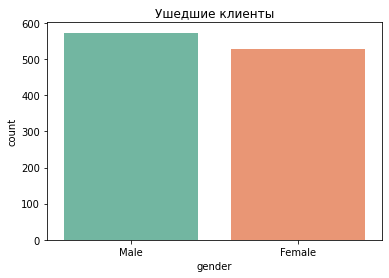

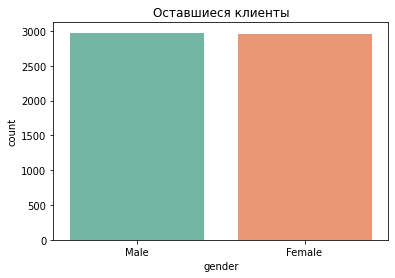

In [23]:
color = sns.color_palette('Set2')
sns.countplot(data=df_gone, x='gender',palette=color)
plt.title('Ушедшие клиенты')
plt.show()
sns.countplot(data=df_stay, x='gender',palette=color,order=['Male','Female'])
plt.title('Оставшиеся клиенты')
plt.show()

На графике видно, что распределение полов ушедших и оставшихся клиентов примерно одинаково.

**SeniorCitizen:**

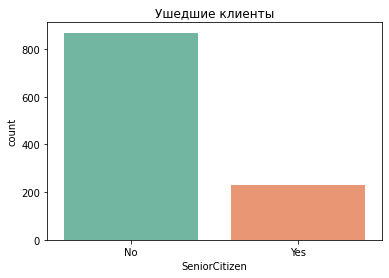

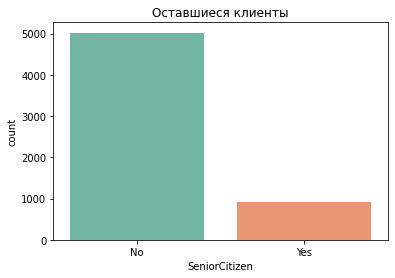

In [24]:
sns.countplot(data=df_gone, x='SeniorCitizen',palette=color)
plt.title('Ушедшие клиенты')
plt.show()
sns.countplot(data=df_stay, x='SeniorCitizen',palette=color)
plt.title('Оставшиеся клиенты')
plt.show()

По графику можно сделать выводы, что процент клиентов, являющихся пожилыми людьми, немного больше в группе ушедших клиентов.

**Partner:**

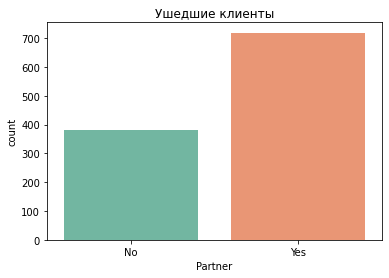

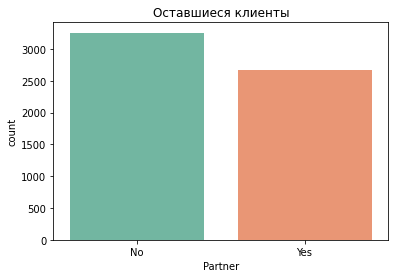

In [25]:
sns.countplot(data=df_gone, x='Partner',palette=color)
plt.title('Ушедшие клиенты')
plt.show()
sns.countplot(data=df_stay, x='Partner',palette=color,order=['No','Yes'])
plt.title('Оставшиеся клиенты')
plt.show()

Что касается наличия партнера, видно, что клиенты, ушедшие с компании, чаще состоят в отношениях. В свою очередь, доля оставшихся клиентов без пары больше. Также стоит отметить, что разница соотношения между данными группами больше у ушедших клиентов, чем у оставшихся.

**Dependents:**

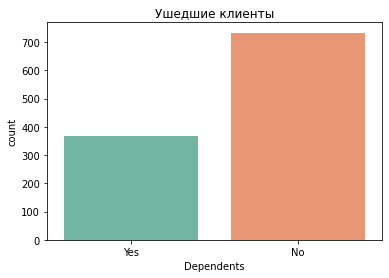

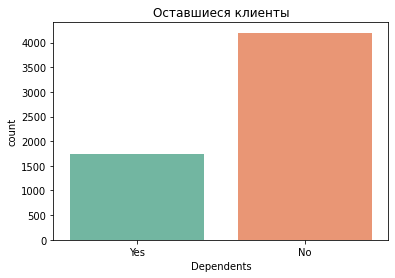

In [26]:
sns.countplot(data=df_gone, x='Dependents',palette=color)
plt.title('Ушедшие клиенты')
plt.show()
sns.countplot(data=df_stay, x='Dependents',palette=color,order=['Yes','No'])
plt.title('Оставшиеся клиенты')
plt.show()

Доля клиентов, у которых есть иждивенцы, немного больше в группе ушедших клиентов.

**Type:**

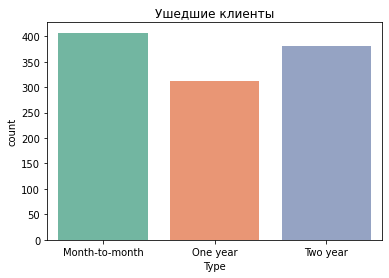

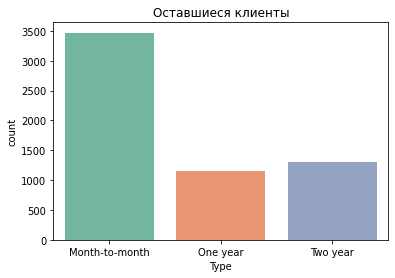

In [27]:
Type_u = df['Type'].unique()
sns.countplot(data=df_gone,x='Type',order=Type_u,palette=color)
plt.title('Ушедшие клиенты')
plt.show()
sns.countplot(data=df_stay, x='Type',order=Type_u,palette=color)
plt.title('Оставшиеся клиенты')
plt.show()

Типы оплаты у групп значительно отличаются - доля годовых подписок у ушедших клиентов значительно больше относительно оставшихся клиентов. Месячный тип подписки популярен в обеих группах.

**PaperlessBilling:**

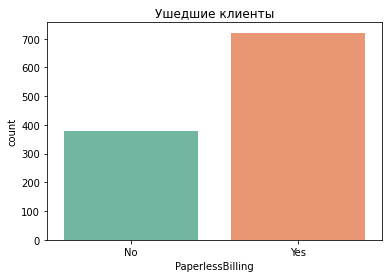

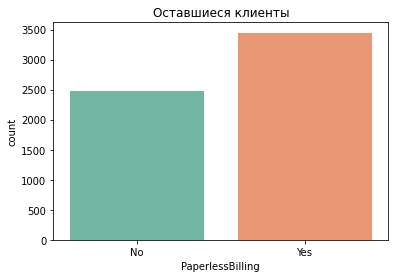

In [28]:
sns.countplot(data=df_gone, x='PaperlessBilling',palette=color)
plt.title('Ушедшие клиенты')
plt.show()
sns.countplot(data=df_stay, x='PaperlessBilling',palette=color,order=['No','Yes'])
plt.title('Оставшиеся клиенты')
plt.show()

Ушедшие клиенты чаще получали бумажные чеки.

**PaymentMethod:**

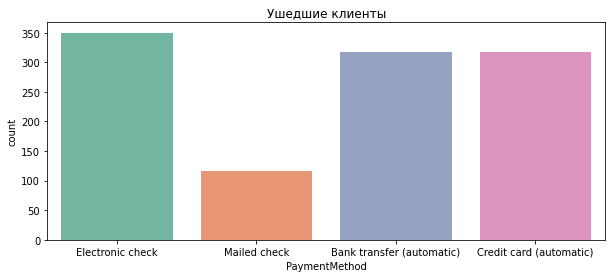

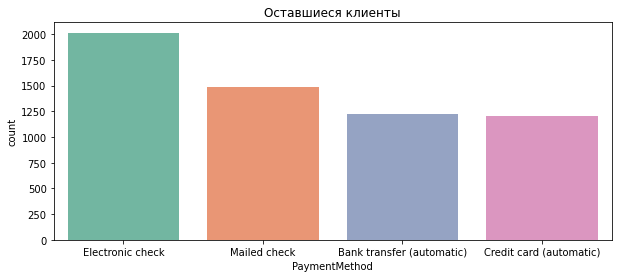

In [29]:
payment_methods = df['PaymentMethod'].unique()
plt.figure(figsize=(10, 4))
sns.countplot(data=df_gone, x='PaymentMethod', order=payment_methods, palette=color)
plt.title('Ушедшие клиенты')
plt.show()
plt.figure(figsize=(10, 4))
sns.countplot(data=df_stay, x='PaymentMethod', order=payment_methods, palette=color)
plt.title('Оставшиеся клиенты')
plt.show()

Таким образом, обе группы клиентов чаще всего получали электронный чек, примерно одинаково оплачивали кредиткой и банковской картой. Однако, у ушедших клиентов значительно меньше получений чека по почте по сравнению с оставшимися клиентами. 

**MonthlyCharges:**

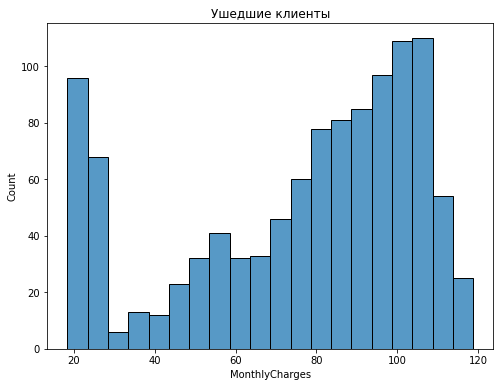

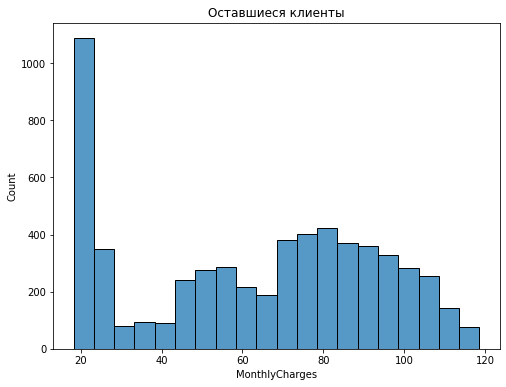

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_gone, x='MonthlyCharges', bins=20)
plt.title('Ушедшие клиенты')
plt.show()
plt.figure(figsize=(8, 6))
sns.histplot(data=df_stay, x='MonthlyCharges', bins=20)
plt.title('Оставшиеся клиенты')
plt.show()

Таким образом, у ушедших клиентов был более высокий средний чек, стремящийся к отметке 105 долларов. У оставшихся клиентов минимальный средний чек, равный приблизительно 18-28 долларов.

**TotalCharges:**

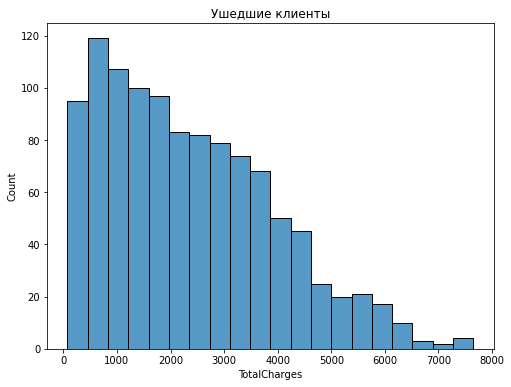

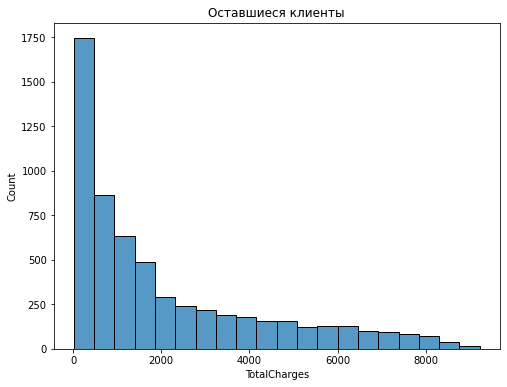

In [31]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_gone, x='TotalCharges', bins=20)
plt.title('Ушедшие клиенты')
plt.show()
plt.figure(figsize=(8, 6))
sns.histplot(data=df_stay, x='TotalCharges', bins=20)
plt.title('Оставшиеся клиенты')
plt.show()

У оставшихся клиентов наблюдается нисходящий тренд суммарных затрат, причем большинство из них тратят минимальную сумму - до 500 долларов. У ушедших же клиентов наблюдается значительный разброс суммарных затрат, а два пика находятся в отметках 1500 и 3000 долларов, что в 3 и 6 раз больше значения пика затрат у оставшихся клиентов соответственно.

**MultipleLines:**

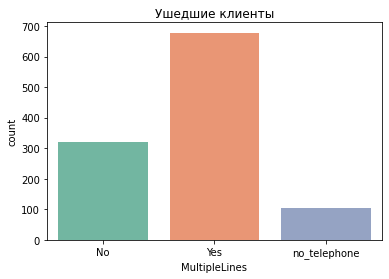

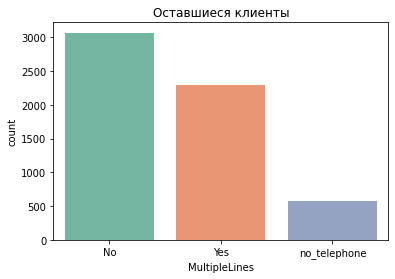

In [32]:
sns.countplot(data=df_gone, x='MultipleLines',palette=color)
plt.title('Ушедшие клиенты')
plt.show()
sns.countplot(data=df_stay, x='MultipleLines',palette=color,order=['No','Yes','no_telephone'])
plt.title('Оставшиеся клиенты')
plt.show()

Ушедшие клиенты представлены большим количеством лиц, для которых предоставлялась возможность ведения параллельных линий. В свою очередь, у большинства оставшихся клиентов данная возможность отсутсвует. Возможно, дело в работе системы обеспечения возможности ведения параллельных линий.

**InternetService:**

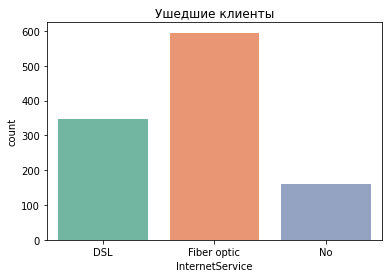

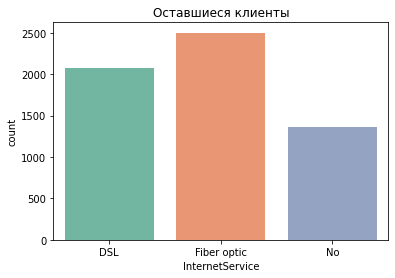

In [33]:
sns.countplot(data=df_gone, x='InternetService',palette=color)
plt.title('Ушедшие клиенты')
plt.show()
sns.countplot(data=df_stay, x='InternetService',palette=color)
plt.title('Оставшиеся клиенты')
plt.show()

У обеих групп клиентов больше всего представлено оптоволоконное соединение. В свою очередь, разница между оптоволоконным соединением и DSL у покинувших компанию клиентов не такая значительная, как у оставшихся клиентов. У покинувшей группы меньше клиентов без подключенного интернета по сравнению с оставшимися пользователями. Так как последующие признаки напрямую связаны с интернетом и могут быть сильно зависимы друг от друга, не будем рассматривать их отдельно и исследуем их при рассмотрении коллинеарности.

**Исследование корреляции признаков:**

Для исследования корреляции, в первую очередь необходимо выделить признаки, которые будут использоваться при обучении модели. В первую очередь, из столбца `EndDate` и `BeginDate` можно определить новый признак, а именно - длительность использования услуг компании. Если клиент ушел, данный признак будет определяться как разность значений `EndDate` и `BeginDate`, если нет-разность даты выгрузки базы данных (1 февраля 2020 года) и `BeginDate`

In [34]:
#определим дату выгрузки датафрейма
data_load = pd.to_datetime('2020-02-01')

#переведем столбцы в формат datetime для дальнейших рассчетов

df['BeginDate'] = pd.to_datetime(df['BeginDate'],format='%Y-%m-%d', errors='coerce')  
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d', errors='coerce')
#так как нам известна чека за месяц, отобразим длительность в месяцах

def calculate_duration(x):
    if pd.isnull(x['EndDate']):
        return (data_load - x['BeginDate']).days
    else:
        return (x['EndDate'] - x['BeginDate']).days 

df['duration'] = (df.apply(calculate_duration, axis=1)).astype(float)

Далее, столбцы `BeginDate` и `EndDate` нам не потребуются, поэтому удалим их:

In [35]:
df.drop(['BeginDate', 'EndDate','customerID'], axis=1, inplace=True)

Выделим из полученного датафрейма признаки для вычисления корреляции:

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'duration']


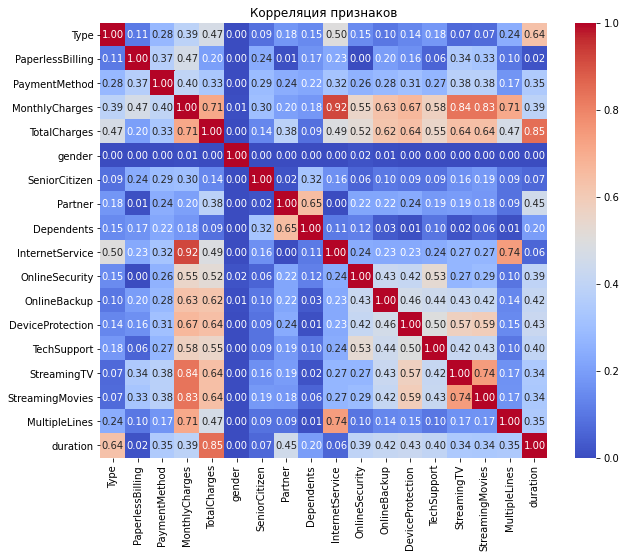

In [36]:
df_cor = df.drop('is_gone',axis=1)
cor = phik_matrix(df_cor)
plt.figure(figsize=(10, 8))
sns.heatmap(cor, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Корреляция признаков")
plt.show()

Исследуем данную тепловую карту корреляции:
1. В первую очередь, наблюдается значительная зависимость(0.62) между `MonthlyCharges` и `TotalCharges`. Это логично, ведь один столбец состоит из суммы другого. Также наблюдается корреляция со столбцом `duration`. В связи с этим целесообразно оставить только один столбец, а именно `MonthlyCharges`;
2. Наблюдается высокая корреляция между интернет-признаками, поэтому, целесообразно оставить только 1 признак - `InternetService`
3. Столбцы `gender` и `Dependents` имеют низкую корреляцию со всеми остальными признаками(за исключением партнеров и возраста, но это обьясняется социальной структурой и поэтому данная корреляция не подходит для задачи проекта), поэтому также не будем использовать их при обучении;

In [37]:
df.drop(['gender','TotalCharges','DeviceProtection','TechSupport','StreamingMovies','OnlineBackup','OnlineSecurity',
         'StreamingTV','Dependents','PaperlessBilling'], axis=1, inplace=True)
display(df.head())

,Type,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,InternetService,MultipleLines,is_gone,duration
0,Month-to-month,Electronic check,29.85,No,Yes,DSL,no_telephone,0,31.0
1,One year,Mailed check,56.95,No,No,DSL,No,0,1036.0
2,Month-to-month,Mailed check,53.85,No,No,DSL,No,0,123.0
3,One year,Bank transfer (automatic),42.30,No,No,DSL,no_telephone,0,1371.0
4,Month-to-month,Electronic check,70.70,No,No,Fiber optic,No,0,153.0


# Обучение модели

Для того, чтобы провести кодирование данных, разделим датафрейм на обучающую и тестовую выборку. Кодирование категориальных признаков происходит после разделения для того, чтобы не было утечки в данных.

In [38]:
RANDOM_STATE = 140823
features = df.drop('is_gone', axis=1)
target = df['is_gone']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                           random_state=RANDOM_STATE, shuffle=True)

Произведем кодирование категориальных признаков. Для этого определим список категориальных признаков и используем OneHotEncoder. Так как мы не используем линейные модели, масштабирование численных признаков не нужно.

In [39]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[ohe_features])
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])
features_train = features_train.drop(ohe_features, axis=1)
#Проведем проверку
display(features_train.head())
features_train.info()

,MonthlyCharges,duration,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_Yes,Partner_Yes,InternetService_Fiber optic,InternetService_No,MultipleLines_Yes,MultipleLines_no_telephone
1723,81.65,1371.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1616,86.45,1126.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5545,20.60,1918.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3580,40.00,215.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1575,71.70,641.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5274 entries, 1723 to 1470
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5274 non-null   float64
 1   duration                               5274 non-null   float64
 2   Type_One year                          5274 non-null   float64
 3   Type_Two year                          5274 non-null   float64
 4   PaymentMethod_Credit card (automatic)  5274 non-null   float64
 5   PaymentMethod_Electronic check         5274 non-null   float64
 6   PaymentMethod_Mailed check             5274 non-null   float64
 7   SeniorCitizen_Yes                      5274 non-null   float64
 8   Partner_Yes                            5274 non-null   float64
 9   InternetService_Fiber optic            5274 non-null   float64
 10  InternetService_No                     5274 non-null   float64
 11  M

**RandomForestClassifier**

In [40]:
# Задаем параметры для поиска
param_dist = {
    'n_estimators': range(1,500,2),
    'max_depth': range(1,5)
}

# Создаем модель RandomForestClassifier
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

scoring=['roc_auc', 'accuracy']
refit = 'roc_auc'

# Создаем объект RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, cv=5, scoring=scoring,
                                   refit=refit)
random_search.fit(features_train, target_train)

# Выводим результаты
print("Лучшие параметры:", random_search.best_params_)
print("Лучшее AUC:", random_search.best_score_)
print("Лучшая модель:", random_search.best_estimator_)

Лучшие параметры: {'n_estimators': 291, 'max_depth': 4}
Лучшее AUC: 0.8156476384201035
Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=291,
                       random_state=140823)


**Catboost**

In [41]:
model = CatBoostClassifier(random_state=RANDOM_STATE)
parametrs = {
    'iterations': range(1,70, 2),
    'depth': range(1,10),
    'learning_rate': [0.01, 0.1, 0.5],
    'l2_leaf_reg': [1, 3, 5]
}
cat_model = RandomizedSearchCV(model, param_distributions = parametrs, scoring=scoring,refit=refit, cv=5)
cat_model.fit(features_train, target_train, verbose=False)
print('Значение метрики модели CatBoost:', np.round(cat_model.best_score_, 2))
print('При гиперпараметрах модели:', cat_model.best_params_)

Значение метрики модели CatBoost: 0.86
При гиперпараметрах модели: {'learning_rate': 0.5, 'l2_leaf_reg': 3, 'iterations': 47, 'depth': 6}


Таким образом, модель catboost дает лучшую метрику на выходе и соответственно может использоваться в качестве основной. 

# Тестирование модели

Протестируем выбранную модель на тестовых данных:

In [42]:
#закодируем данные в тестовой выборке
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
features_test = features_test.drop(ohe_features, axis=1)
predictions = cat_model.predict_proba(features_test)[:, 1]
print('ROC-AUC метрика на тестовых данных составляет', roc_auc_score(target_test, predictions))

ROC-AUC метрика на тестовых данных составляет 0.8759839444455643


Таким образом, точность финальной модели на тестовых данных проходит установленный порог ROC-AUC и может использоваться для прогнозирования оттока клиентов.

# Вывод

Целью данной работы являлось создание такой модели, которая может предсказать потенциальных клиентов, решивших покинуть компанию, для дальнейшей выдачи промокодов, чтобы клиентов сохранить. При исследовательском анализе данных, были выяснены основные различия между оставшимися клиентами и теми, кто покинул компанию. На основе этих данных, а также матрицы корреляции, были выбраны основные признаки, которые будет использовать модель. В итоге, была выбрана модель классификации CatBoost, показавшая метрику 0.88 на тестовых данных (при пороге в 0.85). 